In [1]:
from Bio import SeqIO, Entrez
import subprocess
from io import StringIO

In [2]:
# RNF130
Entrez.email = 'pg52526@alunos.uminho.pt'

orfs = ['RNF130']
ids = ['Q86XS8']
# SALL3 - aminoacid sequence                  Uniprot id = Q62255
# RNF130 - aminoacid sequence                 Uniprot id = Q86XS8
# RIMS2 - SARS-CoV-2 aminoacid sequence       Uniprot id = Q9UQ26

# Fetch the gene sequence using the gene ID or name
# Save it as {gene_name}.fa or .gb
for orf, id in zip(orfs, ids):
    # FASTA
    handle = Entrez.efetch(db="Protein", id=id, rettype="fasta", retmode="text")
    record = handle.read()
    handle.close()
    with open(f"{orf}.fa", "w") as output_file:
        output_file.write(record)

    # GENBANK
    handle = Entrez.efetch(db='Protein', id=id, rettype='gb', retmode='text')
    record = handle.read()
    handle.close()
    with open(f"{orf}.gb", "w") as output_file:
        output_file.write(record)

In [4]:
from Bio.Blast import NCBIWWW, NCBIXML

# Note that this process may takes a few minutes
# Query BLAST with FASTA files
for orf in orfs:
    print("Creating " + orf + " files...")
    # Read the gene sequence from the FASTA file
    with open(f"{orf}.fa", "r") as fasta_file:
        gene_sequence = fasta_file.read()

    # Perform BLAST query against NCBI's database
    result_handle = NCBIWWW.qblast("blastp", "nr", gene_sequence, 
                                   entrez_query='human[Organism]', 
                                   hitlist_size=10)

    # Save the BLAST results in a file
    with open(f"{orf}_blast_results.xml", "w") as output_blast:
        output_blast.write(result_handle.read())
        print(orf + " files successfully created!")

Creating RNF130 files...
RNF130 files successfully created!


In [5]:
import re
import subprocess
from Bio.Blast import NCBIXML
from Bio.Align.Applications import ClustalOmegaCommandline

# Find High-scoring Segment Pairs (HSP) for each orf
for orf in orfs:
    with open(f"{orf}_blast_results.xml", "r") as output_blast:
        blast_records = NCBIXML.parse(output_blast)
        gene_sequences = {}

        for record in blast_records:
            for alignment in record.alignments:
                # Extract the entire title as the gene name
                gene_name = alignment.title

                # Check if the gene name has been seen before
                if gene_name not in gene_sequences:
                    gene_sequences[gene_name] = []
                
                for hsp in alignment.hsps:
                    gene_sequences[gene_name].append(hsp.sbjct)

        sequences = [(gene_name, sequences[0]) for gene_name, sequences in gene_sequences.items()]

    # Perform Multiple Sequence Alignment (MSA)
    alignment_file = f"{orf}_alignment.fa"
    aligned_file = f"{orf}_aligned.fa"
    with open(alignment_file, "w") as out_handle:
        for i, (gene_name, seq) in enumerate(sequences):
            out_handle.write(f">{gene_name}\n{seq}\n")

    # Run Clustal Omega command in WSL
    wsl_command = f"wsl clustalo -i {alignment_file} -o {aligned_file} --verbose --force"
    subprocess.run(wsl_command, check=True)

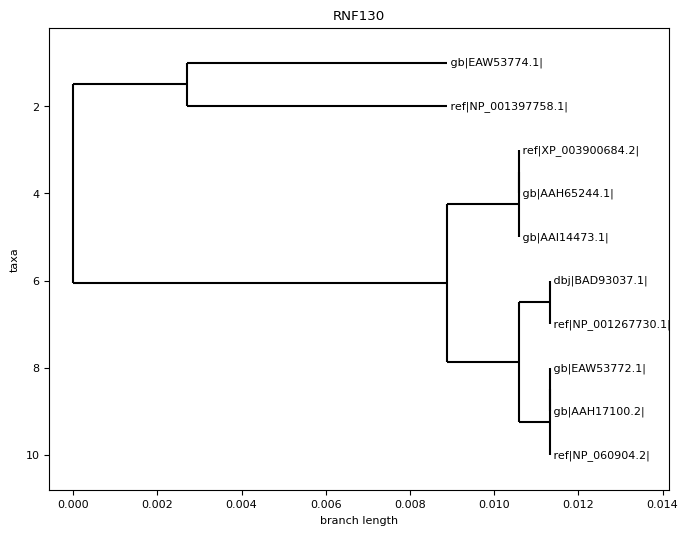

In [6]:
import matplotlib.pyplot as plt
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

plt.rc('font', size=8)
plt.rc('figure', figsize=(8, 6))

# Read the alignment
for orf in orfs:
    alignment = AlignIO.read(f"{orf}_aligned.fa", "fasta")

    # Construct a Phylogenetic Tree
    calculator = DistanceCalculator('blastp')  # Distance calculator method for proteins
    dm = calculator.get_distance(alignment)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(dm)

    # Draw or display the tree
    Phylo.draw(tree, label_func=lambda clade: clade.name if clade.is_terminal() else '', title={'label': orf})

plt.show()